In [4]:
import torch
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import sys
import torch.optim as optim
import numpy as np
import wandb
from torchsummary import summary
import hiddenlayer as hl

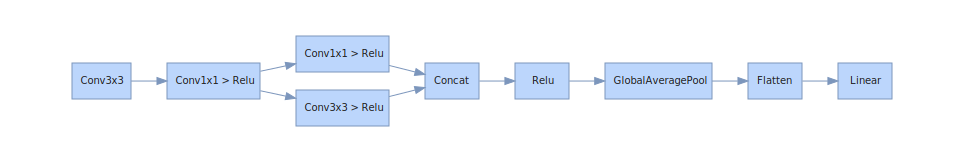

In [9]:
### CREATE MODEL
class FireUnit(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )
        
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2),
            FireUnit(32, 8, 16, 16),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 8)
        )
        
    def forward(self, x):
        x = self.classifier(x)
        return x


net = Net()


hl_graph = hl.build_graph(net, torch.zeros([1, 3, 224, 224]))
hl_graph.theme = hl.graph.THEMES['blue'].copy()
hl_graph.build_dot()